Author: David Sinjaya, Chew Ann Siong

**Summary**:

This notebook uses a sequential model (RNN) to predict the tagging of each token in raw address to either the following class: POI, STREET, OTHERS. Eventually the script will write output as `<predicted POI>/<predicted street>` as the competition's demanded output format.

**Outline**:
1. Import data
2. Preprocess data
3. Split train and validation data
4. Tokenize data
5. Build and train model
6. Inference on Validation set
7. Inference on test set

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import tensorflow as tf
import keras

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sys.path.append('..')

from src.data import raw_to_tokens, tokens_to_tagged, tagged_to_tokens, tagged_to_poi_street, tagged_tokens_to_onehot, get_predicted_tokens
from src import CustomTokenizer

# Import Data

In [2]:
df = pd.read_csv('../data/train.csv').set_index('id')

# Preprocess data

Transform the data into one-hot encoding of token type

In [3]:
df['poi'], df['street'] = zip(*df['POI/street'].str.split('/'))
df['raw_tokens'] = df['raw_address'].apply(raw_to_tokens)
df['poi_tokens'] = df['poi'].apply(raw_to_tokens)
df['street_tokens'] = df['street'].apply(raw_to_tokens)
df['tagged_tokens'] = df.apply(lambda r: tokens_to_tagged(r.raw_tokens, r.poi_tokens, r.street_tokens), axis=1)

In [4]:
test = pd.read_csv('../data/test.csv').set_index('id')

In [5]:
df.head()

,raw_address,POI/street,poi,street,raw_tokens,poi_tokens,street_tokens,tagged_tokens
id,,,,,,,,
0,jl kapuk timur delta sili iii lippo cika 11 a ...,/jl kapuk timur delta sili iii lippo cika,,jl kapuk timur delta sili iii lippo cika,"[jl, kapuk, timur, delta, sili, iii, lippo, ci...",[],"[jl, kapuk, timur, delta, sili, iii, lippo, cika]","[(jl, STREET), (kapuk, STREET), (timur, STREET..."
1,"aye, jati sampurna",/,,,"[aye,, jati, sampurna]",[],[],"[(aye,, OTHER), (jati, OTHER), (sampurna, OTHER)]"
2,setu siung 119 rt 5 1 13880 cipayung,/siung,,siung,"[setu, siung, 119, rt, 5, 1, 13880, cipayung]",[],[siung],"[(setu, OTHER), (siung, STREET), (119, OTHER),..."
3,"toko dita, kertosono",toko dita/,toko dita,,"[toko, dita,, kertosono]","[toko, dita]",[],"[(toko, POI), (dita,, OTHER), (kertosono, OTHER)]"
4,jl. orde baru,/jl. orde baru,,jl. orde baru,"[jl., orde, baru]",[],"[jl., orde, baru]","[(jl., STREET), (orde, STREET), (baru, STREET)]"


In [6]:
df['tokens_onehot'] = df['tagged_tokens'].apply(tagged_tokens_to_onehot)

# Split train and validation data

In [7]:
train, valid = train_test_split(df, test_size=0.1, random_state=42)

In [9]:
texts = df.raw_address.tolist() + test.raw_address.tolist()
len(texts)

350000

# Tokenize data

In [10]:
tokenizer = CustomTokenizer.CustomTokenizer(train_texts = texts)
tokenizer.train_tokenize()

In [11]:
len(tokenizer.tokenizer.word_index.items())

88307

In [12]:
reverse_word_map = dict(map(reversed, tokenizer.tokenizer.word_index.items()))

In [13]:
tokenized_X_train = tokenizer.vectorize_input(train['raw_address'])
tokenized_X_train.shape

(270000, 30)

# Build and train model

In [14]:
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout

In [15]:
num_tokens = len(tokenizer.tokenizer.word_index)+1
latent_dim = 128
batch_size = 256
epochs = 10

In [16]:
input_data = tokenized_X_train
output_data = CustomTokenizer.pad_sequence_tokens(train.tokens_onehot)

In [17]:
input_layer = Input(shape=(None,),name='input')
x = Embedding(num_tokens, latent_dim,name='embedding')(input_layer)
lstm_layer = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True), name='bidirectional_lstm')
output,_,_,_,_ =lstm_layer(x)
dropout_layer = Dropout(0.5, name='dropout')
output = dropout_layer(output)
dense_layer = Dense(3, activation='softmax', name='dense')
output = dense_layer(output)

model = Model(input_layer, output)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history=model.fit(input_data, output_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/10
844/844 [==============================] - 172s 198ms/step - loss: 0.1562 - val_loss: 0.1055
Epoch 2/10
844/844 [==============================] - 167s 198ms/step - loss: 0.1016 - val_loss: 0.0997
Epoch 3/10
844/844 [==============================] - 176s 208ms/step - loss: 0.0958 - val_loss: 0.0984
Epoch 4/10
844/844 [==============================] - 171s 202ms/step - loss: 0.0917 - val_loss: 0.0952
Epoch 5/10
844/844 [==============================] - 171s 203ms/step - loss: 0.0884 - val_loss: 0.0946
Epoch 6/10
844/844 [==============================] - 176s 209ms/step - loss: 0.0852 - val_loss: 0.0947
Epoch 7/10
844/844 [==============================] - 178s 211ms/step - loss: 0.0829 - val_loss: 0.0961
Epoch 8/10
844/844 [==============================] - 167s 198ms/step - loss: 0.0808 - val_loss: 0.0947
Epoch 9/10
844/844 [==============================] - 169s 200ms/step - loss: 0.0787 - val_loss: 0.0950
Epoch 10/10
844/844 [==============================] - 170s 202m

In [18]:
model.save('../model/seq_to_predict_tagging')

INFO:tensorflow:Assets written to: ../model/seq_to_predict_tagging\assets


INFO:tensorflow:Assets written to: ../model/seq_to_predict_tagging\assets


In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         11303424  
_________________________________________________________________
bidirectional_lstm (Bidirect [(None, None, 256), (None 263168    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
dense (Dense)                (None, None, 3)           771       
Total params: 11,567,363
Trainable params: 11,567,363
Non-trainable params: 0
_________________________________________________________________


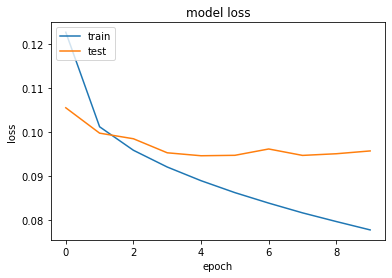

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Inference on Validation set

In [21]:
tokenized_X_valid = tokenizer.vectorize_input(valid['raw_address'])

In [22]:
def predict(tokenized_list, df):
    softmax = model.predict(tokenized_list)
    pred = np.argmax(softmax, axis=-1)
    return pred.tolist()

In [23]:
valid['pred'] = predict(tokenized_X_valid,valid)
valid['reverse_raw_tokens'] = tokenizer.reverse_tokenized_to_array_text(tokenized_X_valid)

D:\Users\Admin\anaconda3\envs\shopee2021\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Users\Admin\anaconda3\envs\shopee2021\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
valid['pred_POI/street'] = valid.apply(lambda x: get_predicted_tokens(x['pred'], x['reverse_raw_tokens']), axis=1)

D:\Users\Admin\anaconda3\envs\shopee2021\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
valid[['POI/street','pred_POI/street']].sample(10)

,POI/street,pred_POI/street
id,,
4361,stasiun klender/,stasiun klender/
136704,/raya maja - ranca,/raya maja ranca
188294,nerada estate/,nerada estate/
34836,/pulau putri x,/pulau putri x
196567,/gg. 8,/gg 8
197068,laundry bintang/raya pasar kec,/raya pasar
15827,/cem g,/cem g
134068,toko abi/raya ngan,toko/raya
142256,/raya roomo,/raya roomo


In [26]:
valid.shape

(30000, 12)

In [27]:
accuracy_score(y_true=valid['POI/street'], y_pred=valid['pred_POI/street'])

0.28873333333333334

# Inference on Test data

In [28]:
tokenized_X_test = tokenizer.vectorize_input(test['raw_address'])

In [29]:
test['pred'] = predict(tokenized_X_test, test)
test['reverse_raw_tokens'] = tokenizer.reverse_tokenized_to_array_text(tokenized_X_test)

In [30]:
test['POI/street'] = test.apply(lambda x: get_predicted_tokens(x['pred'], x['reverse_raw_tokens']), axis=1)

In [31]:
test[['raw_address','POI/street']].sample(10)

,raw_address,POI/street
id,,
46523,"sman 1 kau, desa kau, kauman",sman 1/
22721,lemb 47 menteng 7 menteng,/lemb
10782,paw cikampek,/
38162,"toko elektr, anyar 1, no 37 rw 10",toko/anyar
44746,pem rt. 01 sedayu rt 1 muntilan,/pem
29218,gandaria utara karya utama 13-22 5 12140 kebay...,/karya utama
18331,kedaung kali angke h.na 93 rt 3 4 cengkareng,/h
42328,"pondok bambu bet raya, 287 rt 9 rw 8 duren sawit",/bambu bet raya
38983,sunter agung agung barat 42 17 rt 6 16 14350 t...,/agung agung barat


In [31]:
# Save prediction
test['POI/street'].to_csv('../data/pred.csv')

In the end, test performance is similar with validation performance.